# Useful code 

hopefully, this should contain some example code snippets to help you make maps and interactives

In [1]:
# Useful Libraries 
import pandas as pd
import intake 
import geopandas as gpd
import laplan
import intake_dcat 
import ipywidgets
import IPython.display


from ipywidgets import interact
import contextily
import matplotlib.pyplot as plt
import scipy.constants as constants


In [2]:
# Data Catalog 
catalog = intake.open_catalog('../catalog.yml')

## Make a map of LA zoning and transit lines 

This map will show all  areas with in a quater mile of a metro rail stop, as an example, that are zoned for R1 or other low densities

In [4]:
zoning = catalog.zoning.read()

In [5]:
# Filter the zoning data by zone classes which are low density 
low_density_zoning = zoning[
    zoning.ZONE_CLASS.isin(
        [
            'C1',
            'C1.5',
            'R1',
            'RD1.5',
            'RD2',
        ]
    )
]
low_density_zoning.head()

,OBJECTID,ZONE_CMPLT,ZONE_CLASS,ZONE_SMRY,SHAPE_Length,SHAPE_Area,geometry
22,23,(Q)C1.5-1,C1.5,COMMERCIAL,0.001151,7.920317e-08,"MULTIPOLYGON (((-118.57494 34.20903, -118.5749..."
23,24,(Q)C1.5-1,C1.5,COMMERCIAL,0.005080,9.174326e-07,"MULTIPOLYGON (((-118.56156 34.27577, -118.5611..."
24,25,(Q)C1.5-1,C1.5,COMMERCIAL,0.003634,2.849384e-07,"MULTIPOLYGON (((-118.60582 34.21877, -118.6058..."
25,26,(Q)C1.5-1L,C1.5,COMMERCIAL,0.003444,3.583232e-07,"MULTIPOLYGON (((-118.60526 34.22131, -118.6052..."
26,27,(Q)C1.5-1-RIO,C1.5,COMMERCIAL,0.001430,9.090309e-08,"MULTIPOLYGON (((-118.60670 34.19856, -118.6067..."


In [6]:
# load the metro rail network 
rail_stops = catalog.metro_rail_stations.read()

# buffer it and grab the areas 
FT_PER_MILE = 5280
elibigle_areas = rail_stops.to_crs('epsg:2229').buffer(FT_PER_MILE / 4)
elibigle_areas.head()

0    POLYGON ((6504350.095 1738033.828, 6504343.739...
1    POLYGON ((6504116.262 1739558.050, 6504109.906...
2    POLYGON ((6505434.567 1743039.068, 6505428.211...
3    POLYGON ((6505440.153 1745681.180, 6505433.797...
4    POLYGON ((6505315.170 1752228.119, 6505308.814...
dtype: geometry

In [7]:
# intersect the selected zones 
union = low_density_zoning.buffer(0).unary_union

In [8]:
type(union)

shapely.geometry.multipolygon.MultiPolygon

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: The "contextily.tile_providers" module is deprecated and will be removed in contextily v1.1. Please use "contextily.providers" instead.
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.
  """


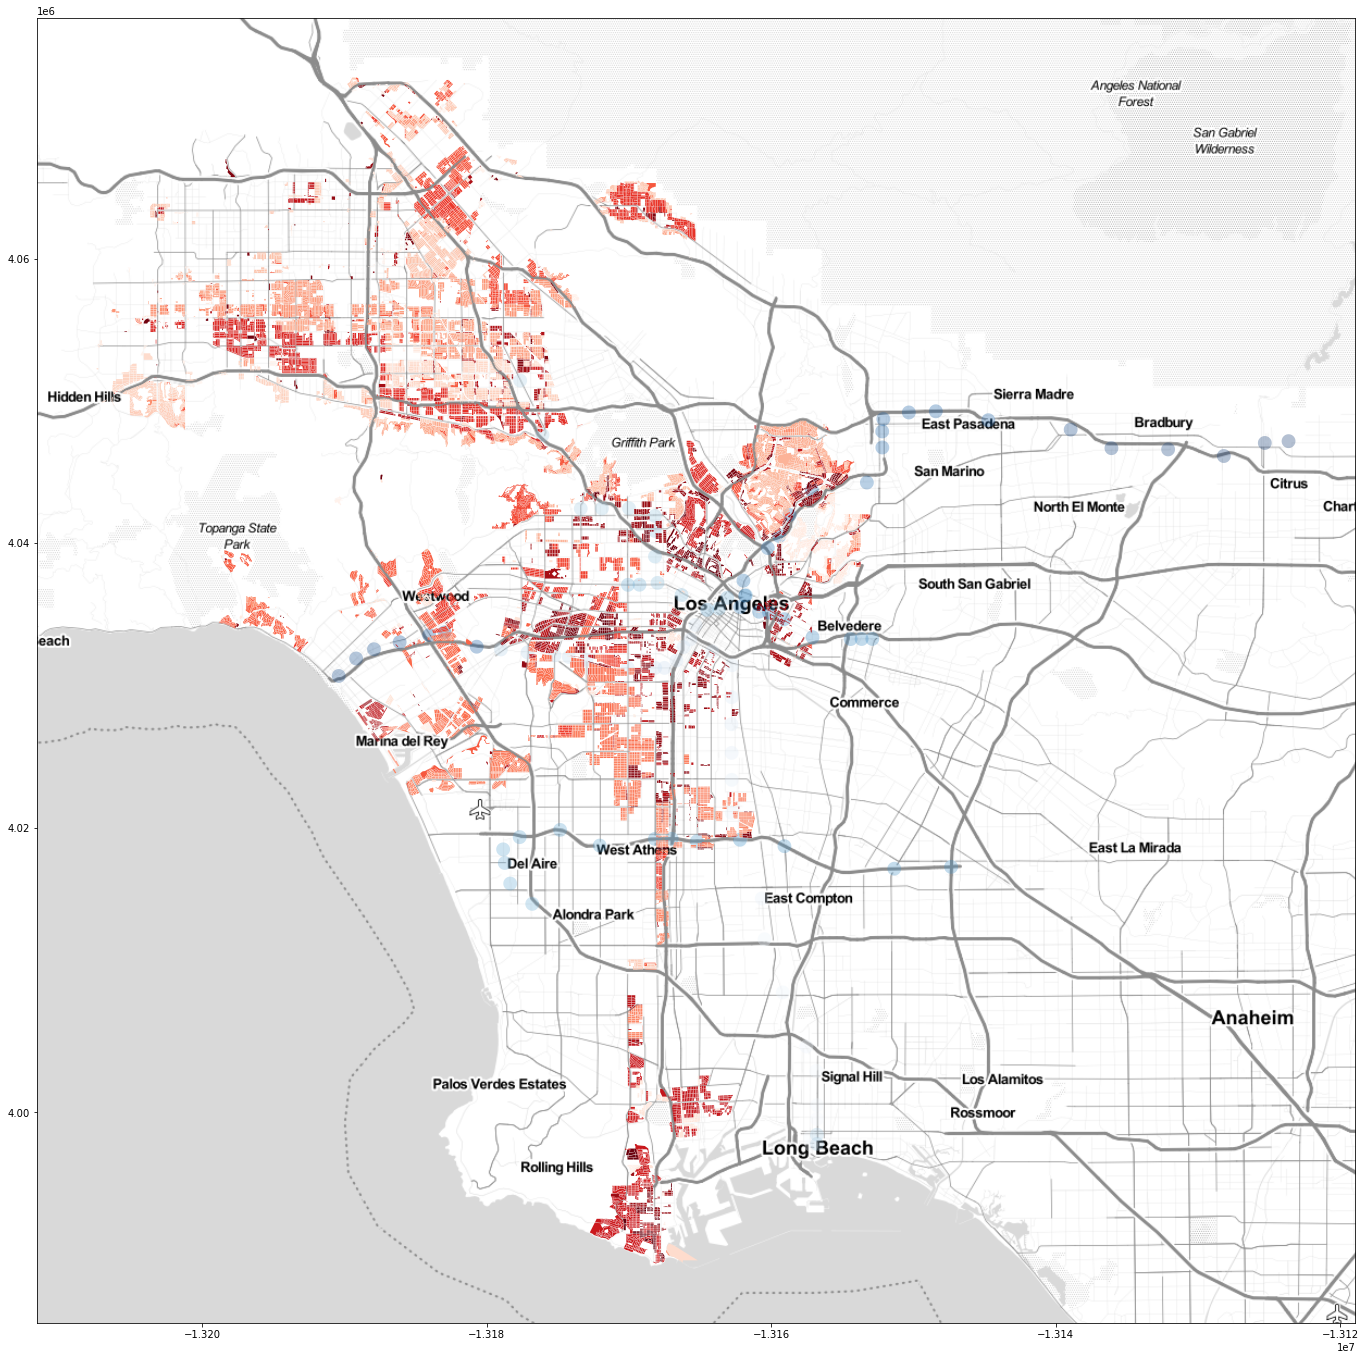

In [9]:
WEB_MERCATOR = 3857
fig, ax = plt.subplots(figsize=(24,24))
elibigle_areas.to_crs(epsg=WEB_MERCATOR).plot(alpha=0.3, cmap="Blues", ax=ax)
low_density_zoning.to_crs(epsg=WEB_MERCATOR).plot(cmap="Reds", ax=ax)
contextily.add_basemap(ax, url=contextily.sources.ST_TONER_LITE)

## Interactive Sliders 
Let's make a few different slides

In [10]:
years = list(range(2010, 2020))

In [11]:
def year_function(year):
    return f"The year is {year}"

interact(year_function, year=years); # the semicolon at the end supresses jupyter output 

interactive(children=(Dropdown(description='year', options=(2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 20…

Let's make a more complex one, that show census tracts with a number of non -car commuters above a certain number 


In [12]:
def census_function(threshold):
    df = pd.read_parquet("https://storage.googleapis.com/usc-price-workshop/census_analysis_table.parquet")
    subset = df[df.non_car_workers > threshold]
    return display(subset)

interact(census_function, threshold=50);

interactive(children=(IntSlider(value=50, description='threshold', max=150, min=-50), Output()), _dom_classes=…

Finally, let's update map of census tracts in an interactive form. 

In [13]:
df = pd.read_parquet("https://storage.googleapis.com/usc-price-workshop/census_analysis_table.parquet")

def census_map_maker(threshold, column):
    """
    shows a map of cesnus tage based on a threshold selector
    """
    census_geoms = catalog.census_tracts.read()
    joined = census_geoms.set_index('GEOID').join(df.set_index('GEOID'))
    subset = joined[joined.pct_non_car_workers > threshold]
    fig, ax = plt.subplots(figsize=(24,24))
    subset.to_crs(epsg=WEB_MERCATOR).plot(cmap="Reds", ax=ax, column = column)
    contextily.add_basemap(ax, url=contextily.sources.ST_TONER_LITE)
    return display(fig)

interact(census_map_maker, threshold=.5, column=df.columns[df.columns.str.startswith('pct')]);

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.5, min=-0.5), Dropdown(description…

# Census Data Notes

In [14]:
#catalog.census_analysis_table.read()

# if this fails, run the following line instead

df = pd.read_parquet("https://storage.googleapis.com/usc-price-workshop/census_analysis_table.parquet")
df

In [ ]:
# give me non car works, that pct

# use the `laplan` functions if you want to transform the raw data, but can start with catalog version to start

## Joining Assesor Parcels to Zoning

In [23]:
parcels_df = pd.read_csv('https://data.lacounty.gov/api/views/mk7y-hq5p/rows.csv?accessType=DOWNLOAD')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (37) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [34]:
parcels_df= parcels_df[parcels_df.City == 'LOS ANGELES CA']

gdf = gpd.GeoDataFrame(
    parcels_df[parcels_df.City == 'LOS ANGELES CA'], geometry=gpd.points_from_xy(parcels_df.CENTER_LON, parcels_df.CENTER_LAT))

In [ ]:
gdf = gdf[gdf.geometry.is_valid == True]
gdf = gdf.set_crs("EPSG:4326")
joined = gpd.sjoin(gdf, zoning, how='inner', op='intersects')

In [46]:
joined[joined.ZONE_CLASS.isin(['R1', 'R2'])]

,ZIPcode,TaxRateArea_CITY,AIN,RollYear,TaxRateArea,AssessorID,PropertyLocation,PropertyType,PropertyUseCode,GeneralUseType,...,CENTER_LON,Location 1,geometry,index_right,OBJECTID,ZONE_CMPLT,ZONE_CLASS,ZONE_SMRY,SHAPE_Length,SHAPE_Area
1,90068-2219,LOS ANGELES,5585016055,2018,13,5585-016-055,6225 QUEBEC DR LOS ANGELES CA 90068,SFR,0101,Residential,...,-118.324824,"(34.113962558188, -118.324823860089)",POINT (-118.32482 34.11396),27279,27280,R1-1,R1,RESIDENTIAL,0.002496,2.364136e-07
3,90068-2725,LOS ANGELES,5577027040,2018,13,5577-027-040,2323 LORENZO DR LOS ANGELES CA 90068,SFR,0101,Residential,...,-118.332401,"(34.112817760514, -118.332400875789)",POINT (-118.33240 34.11282),27235,27236,R1-1,R1,RESIDENTIAL,0.011654,1.682649e-06
4,90068-2842,LOS ANGELES,5576016040,2018,13,5576-016-040,2200 WILLETTA ST LOS ANGELES CA 90068,SFR,0100,Residential,...,-118.327559,"(34.11090117492, -118.327559029383)",POINT (-118.32756 34.11090),27183,27184,R1-1,R1,RESIDENTIAL,0.004654,9.092450e-07
10,90046-1920,LOS ANGELES,5556017032,2018,67,5556-017-032,8484 GRAND VIEW DR LOS ANGELES CA 90046,SFR,0100,Residential,...,-118.375139,"(34.1036476838, -118.375139279867)",POINT (-118.37514 34.10365),33881,33882,R1-1-HCR,R1,RESIDENTIAL,0.004484,5.411959e-07
13,90069-1641,LOS ANGELES,5555026028,2018,67,5555-026-028,8368 HOLLYWOOD BLVD LOS ANGELES CA 90069,R-I,0201,Residential,...,-118.370918,"(34.098852957214, -118.370918053417)",POINT (-118.37092 34.09885),33912,33913,R1-1-HCR,R1,RESIDENTIAL,0.027131,6.532823e-06
26,90038-4102,LOS ANGELES,5535014029,2018,67,5535-014-029,743 N GRAMERCY PL LOS ANGELES CA 90038,VAC,010V,Residential,...,-118.313421,"(34.08463513765, -118.313421499088)",POINT (-118.31342 34.08464),41900,41901,R2-1XL,R2,RESIDENTIAL,0.007106,1.255017e-06
52,90039-3024,LOS ANGELES,5431025034,2018,13,5431-025-034,1911 REDCLIFF ST LOS ANGELES CA 90039,SFR,0100,Residential,...,-118.270837,"(34.094555902984, -118.270836842287)",POINT (-118.27084 34.09456),36528,36529,R1-1VL,R1,RESIDENTIAL,0.011138,4.167330e-06
53,90026-2420,LOS ANGELES,5423011042,2018,13,5423-011-042,1621 MOHAWK ST LOS ANGELES CA 90026,SFR,0100,Residential,...,-118.261367,"(34.085520870635, -118.261367239329)",POINT (-118.26137 34.08552),41502,41503,R2-1VL,R2,RESIDENTIAL,0.005926,1.457304e-06
98,90019-4922,LOS ANGELES,5068026030,2018,67,5068-026-030,1530 S ORANGE GROVE AVE LOS ANGELES CA 90019,R-I,0200,Residential,...,-118.365549,"(34.048784909291, -118.365549279822)",POINT (-118.36555 34.04878),41315,41316,R2-1-O,R2,RESIDENTIAL,0.004798,8.121238e-07
160,90045-2016,LOS ANGELES,4103015033,2018,68,4103-015-033,7207 S LA CIENEGA BLVD LOS ANGELES CA 90045,R-I,0200,Residential,...,-118.371840,"(33.9706153841, -118.371840265984)",POINT (-118.37184 33.97062),29964,29965,R1-1,R1,RESIDENTIAL,0.005666,1.610867e-06


In [52]:
print(f"the money raised from this tax is {(joined.TotalValue / 100_000 * 10).sum()} per year")

the money raised from this tax is 28406.603399999996 per year
